# Comparing axis-aligned decision tree versus oblique decision tree on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using `2` more custom simulation datasets: `sparse_parity`, `trunk` along with other simulation datasets from scikit-learn datasets module

## Environment
- Python 3.8.10
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquetrees)

## Import packages

In [1]:
import sklearn
from sklearn.tree import DecisionTreeClassifier, ObliqueDecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_low_rank_matrix, make_multilabel_classification, \
                            make_circles, make_moons, make_hastie_10_2, make_blobs, \
                            make_sparse_uncorrelated, make_gaussian_quantiles

from datetime import datetime
from tqdm import tqdm
import itertools
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sklearn.__version__

'1.1.dev0'

In [2]:
today = str(datetime.now().date())
today

'2022-05-20'

#### Generating custom simulation datasets

In [3]:
def sparse_parity(n_samples, p=20, p_star=3, noise=None, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

def trunk(n_samples, p=10, noise=None, random_seed=None, **kwarg):

    if random_seed: 
        np.random.seed(random_seed)

    mu_1 = np.array([1/i for i in range(1,p+1)])
    mu_0 = -1 * mu_1

    cov = np.identity(p)

    X = np.vstack((
        np.random.multivariate_normal(mu_0, cov, int(n_samples/2)),
        np.random.multivariate_normal(mu_1, cov, int(n_samples/2))
        ))

    y = np.concatenate((
        np.zeros(int(n_samples/2)),
        np.ones(int(n_samples/2))
        ))

    return X, y

In [4]:
def scores(func, n, m=None, o=None):
    if m:
        k = {'noise': m}
    else:
        k = {}

    if o: k['n_features'] = o
    if n: k['n_samples'] = n

    X_train, y_train = func(**k)
    X_test, y_test = func(**k)

    clfs = [
        RandomForestClassifier(**kwarg),
        ObliqueRandomForestClassifier(**kwarg)
    ]

    tmp = []

    for clf in clfs:
        clf.fit(X_train,y_train)
        
        tmp.append(
            accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))
        )

    return tmp

In [5]:
def run_experiment():
    nn = [100, 1000, 5000, 10000]
    accs = []

    for n in tqdm(nn):
        args = [
            ['sparse_parity', sparse_parity, n],
            ['trunk', trunk, n],
            # ['make_blobs', make_blobs, n, None, 10],
            ['make_gaussian_quantiles', make_gaussian_quantiles, n, None, 10], #noise, n_features
            ['make_circles', make_circles, n, 0.3], #noise
            ['make_moons',make_moons, n, 0.4],
            ['make_hastie_10_2',make_hastie_10_2, n]
        ]
        for arg in args:
            for i in range(10):
                acc = scores(*arg[1:])
                accs.append([arg[0], n, i] + acc)

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    df = pd.DataFrame(accs, columns=['d', 'n', 'i', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    sns.barplot(data=df, x='n', y='delta', hue='d', ax=ax)

100%|██████████| 4/4 [04:56<00:00, 74.01s/it]


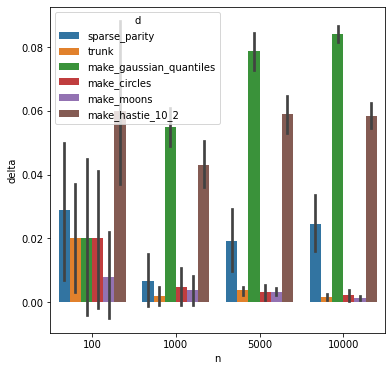

In [6]:
kwarg = {
'max_features': 2,
'max_depth': 10}

run_experiment()

100%|██████████| 4/4 [01:17<00:00, 19.43s/it]


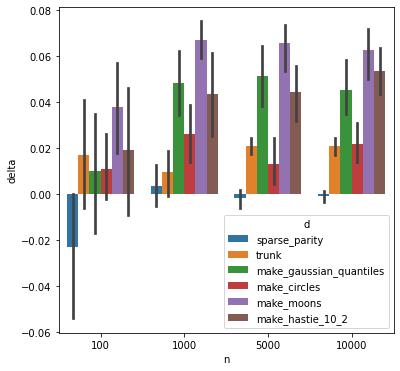

In [7]:
kwarg = {
'max_features': 2,
'max_depth': 1}

run_experiment()